In [23]:
from tensorflow.keras.layers import StringLookup
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

## Preparing and Preprocessing Data

The data set has 2 sections. 'words.txt' is the first section where it lists the file name, and then the corresponding information

format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A

     - a01-000u-00-00  -> word id for line 00 in form a01-000u (file name)
     - ok              -> result of word segmentation
                            ok: word was correctly
                            err: segmentation of word can be bad

     - 154             -> graylevel to binarize the line containing this word
     - 1               -> number of components for this word
     - 408 768 27 51   -> bounding box around this word in x,y,w,h format
     - AT              -> the grammatical tag for this word, see the
                        file tagset.txt for an explanation
     - A               -> the transcription for this word

Data (data/words.tgz) downloaded from [IAM Database](https://fki.tic.heia-fr.ch/databases/download-the-iam-handwriting-database)

In [24]:
base_path = '../data/IAM_Words'

In [31]:
words_list = []

words = open(f'{base_path}/words.txt', 'r').readlines()
for line in words: # go line by line
    if (line[0] != "#") and (line.split()[1] != "err"): # lines that begin with #, are useless. Ignoring errored entries as well
        
        words_list.append(line)
        

96,456 handwritten words - note that words_list is just the 'keys' of the images. We will be accessing the actual images through a function that exploits the 

In [32]:
len(words_list)

96456

### Train-Validation-Test Split

First scrambling the 'keys'

In [33]:
np.random.shuffle(words_list)

Now I'm splitting the data. 

90% will be used for training

In [34]:
split = int(0.9 * len(words_list)) # index to split train on
train = words_list[:split] # shuffled already so this is ok
test = words_list[split:]

The remaining test, will be split in half; test and val. The model will never see the new test

In [35]:
test_split = int(0.5 * len(test))
val = test[:test_split]
test= test[test_split:]

In [39]:
train[2]

'd06-003-04-04 ok 155 1051 1445 339 127 VBN molly-coddled\n'

In [40]:
train[2].strip()

'd06-003-04-04 ok 155 1051 1445 339 127 VBN molly-coddled'

### Dealing with the images

Again, words_list, train, test, and val are all 'pointers'/'keys' that point towards the actual image files

In [36]:
base_images_path = os.path.join(base_path, 'words')

First, here's a function that extracts the filepath names and labels(ys)

In [41]:
def get_paths_and_labels(IAM_keys):
    '''
    Input: IAM_keys = train, val, or test
    Output: paths, labels
            paths: full paths to access the png images
            labels: corresponding label for each image
    
    '''
    paths = []
    labels = []
    for key in IAM_keys:
        
        key_info = key.strip().split()

        # Each line split will have this format for the corresponding image:
        # train[2] is 'd06-003-04-04 ok 155 1051 1445 339 127 VBN molly-coddled\n'
        # the corresponding file path is words/d06/d06-003/d06-003-04-04.png .. which is all gained from the first element of the split() string
        img_name = key_info[0] # img_name is now d06-003-04-04 (using above example)
        
        pseudo_name = img_name.split("-")
        folder_1 = pseudo_name[0]
        folder_2 = pseudo_name[0] + '-' + pseudo_name[1]
        img_name += '.png'
        
        img_path = os.path.join(
            base_images_path, 
            folder_1, 
            folder_2, 
            img_name
        )
        
        paths.append(img_path)
        labels.append(key.strip())
        

    return paths, labels

In [42]:
train_paths, train_labels = get_paths_and_labels(train)
val_paths, validation_labels = get_paths_and_labels(val)
test_paths, test_labels = get_paths_and_labels(test)

In [44]:
train_labels[2]

'd06-003-04-04 ok 155 1051 1445 339 127 VBN molly-coddled'

In [47]:
print(train_paths[2])

../data/IAM_Words\words\d06\d06-003\d06-003-04-04.png


<img src= ../data/IAM_Words\words\d06\d06-003\d06-003-04-04.png>

In [48]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split()[-1].strip() # last is label
        cleaned_labels.append(label)
    return cleaned_labels

train_labels_cleaned = clean_labels(train_labels)
validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

In [49]:
train_labels_cleaned[2]

'molly-coddled'

Finding the max number of characters in a label for the entire corpus of train labels. and then getting every unique character in that corpus(characters set) 

In [53]:
characters = set()

max_len = 0 

for label in train_labels_cleaned:
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))

characters = sorted(list(characters))

print("max length: ", max_len)
print("vocab size: ", len(characters))

print(characters)

max length:  21
Vocab size:  78
['!', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [55]:
len(['!', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/',':', ';', '?'])

16

So there are 26 letters ( 52 lower and upper) + 10 digits + 16 chars(look at cell above) = 78 vocab size

## Preprocessing images

[Used this](https://keras.io/guides/preprocessing_layers/) to create a 'tokenize' and 'untokenize' objects/mappers

In [59]:
AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
tokenize = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
untokenize = StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

Standards for our images

In [60]:
batch_size = 64
padding_token = 99
image_width = 128 
image_height = 32

Preprocessing Functions from [here](https://keras.io/examples/vision/handwriting_recognition/)

These are utility functions to preprocess the images

In [64]:
def distortion_free_resize_padding(image, img_size):
    '''
    Used in the preprocess_image() function to resize and pad images without losing aspect ratio
    '''
    
    w, h = img_size
    image = tf.image.resize(image, 
                            size=(h, w), # A 1-D int32 Tensor of 2 elements: new_height, new_width. The new size for the images.
                            preserve_aspect_ratio=True)

    # Check the amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0] # tf.shape - gives (h,w)
    pad_width = w - tf.shape(image)[1]

    # Now that image is resized, we need to determine the padding.
    
    # First, the top and bottom padding
    
    if pad_height % 2 != 0: 
        height = pad_height // 2
        top = height + 1
        bottom = height
    else:
        top = pad_height // 2
        bottom = top
        
    # now left and right padding
    if pad_width % 2 != 0:
        width = pad_width // 2
        left = width + 1
        right = width
    else:
        left = pad_width // 2
        right = left
    

    image = tf.pad(
        image,
        paddings=[
            [top, bottom],
            [left, right],
            [0, 0], # 3 rank vector - this dimension is the channels
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2]) # https://www.tensorflow.org/api_docs/python/tf/transpose
    image = tf.image.flip_left_right(image) # correction after above line
    return image



def preprocess_image(image_path, img_size=(image_width, image_height)):
    '''
    Reads image from path provided, resizes and pads it
    '''
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

This is a utility function to preprocess the labels 

In [63]:
def vectorize_label(label):
    '''
    Vectorizes the labels and pads them to the max_len amount ... which is 21
    '''
    
    label = tokenize(tf.strings.unicode_split(label, input_encoding="UTF-8")) # tokenize is the StringLookup object defined above
    length = tf.shape(label)[0]
    
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label

This function puts them all together

In [65]:
def process_images_labels(image_path, label):
    '''
    Processes image and label
    
    '''
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}

In [66]:
def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

train_ds = prepare_dataset(train_paths, train_labels_cleaned)
validation_ds = prepare_dataset(val_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_paths, test_labels_cleaned)

In [67]:
type(train_ds)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

Just visualizing the pads

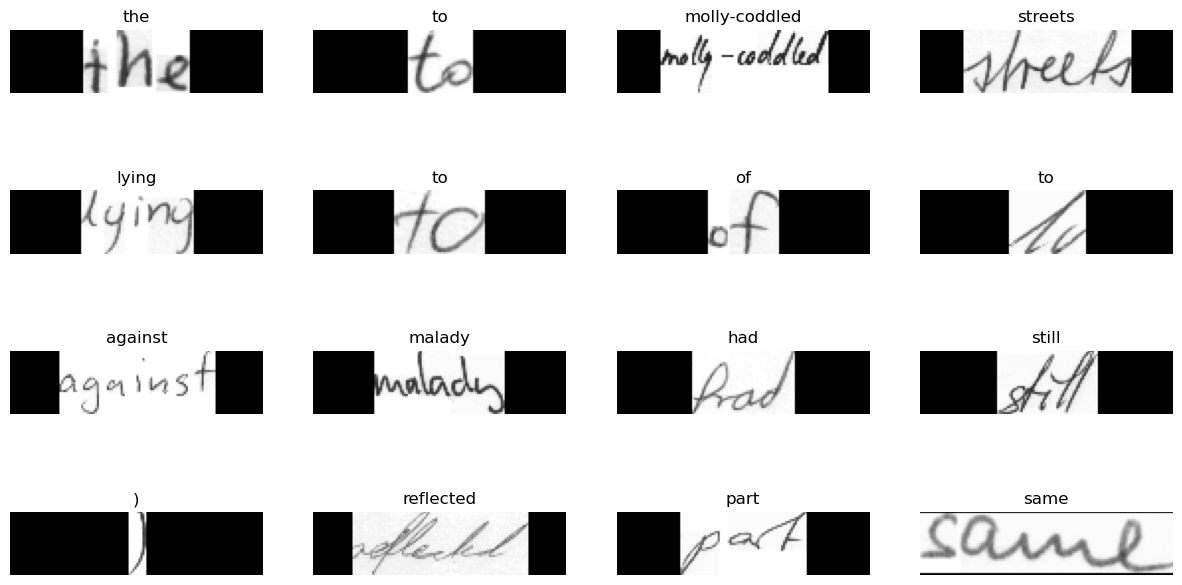

In [70]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()

## Modeling

In [71]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred

In [72]:
def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs.
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model


# Get the model.
model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 128, 32, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 32, 32)          320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 64, 16, 32)           0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 64, 16, 64)           18496     ['pool1[0][0]']               
                                                                             

## Model Evaluation Metrics

In [13]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

In [14]:
def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )

In [14]:
def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )

In [18]:
epochs = 10  # To get good results this should be at least 50.

model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback],
)

Epoch 1/10
1/1 [==============================] - 2s 2s/step
Mean edit distance for epoch 1: 20.3704
1357/1357 [==============================] - 299s 214ms/step - loss: 13.6331 - val_loss: 11.6464
Epoch 2/10
1/1 [==============================] - 0s 43ms/step
Mean edit distance for epoch 2: 20.0658
1357/1357 [==============================] - 280s 206ms/step - loss: 10.7823 - val_loss: 9.5424
Epoch 3/10
1/1 [==============================] - 0s 41ms/step
Mean edit distance for epoch 3: 19.7065
1357/1357 [==============================] - 276s 204ms/step - loss: 9.1555 - val_loss: 7.9104
Epoch 4/10
1/1 [==============================] - 0s 45ms/step
Mean edit distance for epoch 4: 19.0796
1357/1357 [==============================] - 269s 198ms/step - loss: 7.6343 - val_loss: 6.1956
Epoch 5/10
1/1 [==============================] - 0s 45ms/step
Mean edit distance for epoch 5: 18.4989
1357/1357 [==============================] - 267s 197ms/step - loss: 6.2558 - val_loss: 4.8672
Epoch 6/1

2/2 [==============================] - 0s 38ms/step


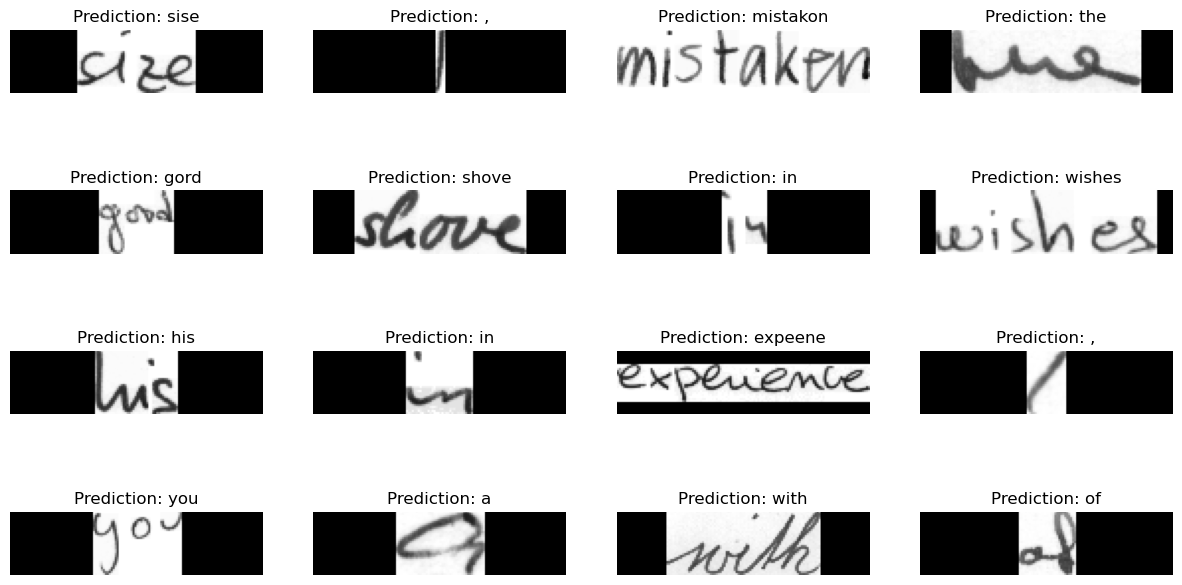

In [19]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()